Jiayuan Zhu，  JIAYUANZ3，   1067734

Junjie Wu， junjie1,   981072

Yingjun Lu，    yingjun，   980928

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textdistance
from collections import defaultdict
import textdistance as td
from sklearn.decomposition import PCA 
import seaborn as sns
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures as PF
poly = PF(interaction_only = True)
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
import random

# Part 1 - Data Linkage

In [4]:
# Part1 Naive data linkage without blocking
# Import CSV files
amazon_small = pd.read_csv('amazon_small.csv', encoding = 'ISO-8859-1')
google_small = pd.read_csv('google_small.csv', encoding = 'ISO-8859-1')
amazon_google_truth_small = pd.read_csv('amazon_google_truth_small.csv', encoding = 'ISO-8859-1')
truth_pair_dictonary = defaultdict()
false_pair_dictonary = defaultdict()
max_sim_list = []

# Find the threshold by create a list of max_sim first
for i in (google_small.index):
    sim_list = []
    for j in (amazon_small.index):
        sim = textdistance.jaccard.normalized_similarity(google_small['name'][i].split(), amazon_small['title'][j].split()) 
        sim_list.append(sim)
    max_sim_list.append(max(sim_list))   
# It's reasonable for a dataset to have 87.5% real linkages
threshold = sorted(max_sim_list)[int(len(max_sim_list)/8)]
# In case of the similarity is too low, give the threshold a lowest standard
if threshold < 0.15:
    threshold = 0.15  
    
# Find similarity of each google and amazon pair
for i in (google_small.index):  
    sim_list = []
    dictonary = defaultdict()
    for j in (amazon_small.index):
        sim = textdistance.jaccard.normalized_similarity(google_small['name'][i].split(), amazon_small['title'][j].split())      
        dictonary[sim] = amazon_small['idAmazon'][j]
        sim_list.append(sim)

    # Find linking google and amazon pair by highest similarity
    # If the highest similarity is greater than threshold, then it's a valid pair, vice verse
    if (max(sim_list) > threshold):
        truth_pair_dictonary[google_small['idGoogleBase'][i]] = dictonary[max(sim_list)]
    else:
        false_pair_dictonary[google_small['idGoogleBase'][i]] = dictonary[max(sim_list)]
        
# Create the true linking google and amazon pair
truth_dictonary = defaultdict()
for i in (amazon_google_truth_small.index):
    truth_dictonary[amazon_google_truth_small['idGoogleBase'][i]] = amazon_google_truth_small['idAmazon'][i]  

In [5]:
tp = 0
fp = 0
tn = 0
fn = 0
for element in google_small.iloc[:, 0]:
    if element in list(truth_pair_dictonary):
        if element in list(amazon_google_truth_small.iloc[:, 1]):
            # True positive happens when both prediction and fact showsthere's a linkage
            if truth_pair_dictonary[element] == truth_dictonary[element]:
                tp = tp + 1
            else:
                fp = fp + 1
        # False positive happens when only prediction shows there's a linkage
        else:
            fp = fp + 1
            
    if element in list(false_pair_dictonary):
        # True negative happens when both prediction and fact show there's no linkage
        if element not in (truth_dictonary.keys()):
            tn = tn + 1
        # False negative happens when only fact shows there's a linkage
        else:
            fn = fn + 1
print(f'The number of true positive is {tp}.')
print(f'The number of false positive is {fp}.')
print(f'The number of true negative is {tn}.')
print(f'The number of false negative is {fn}.')
recall = tp / (tp + fn)
print(f'The recall is found to be {recall}.')
precision = tp /(tp + fp)
print(f'The precision is found to be {precision}.')
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f'The accuracy is found to be {accuracy}.')

The number of true positive is 117.
The number of false positive is 14.
The number of true negative is 11.
The number of false negative is 8.
The recall is found to be 0.936.
The precision is found to be 0.8931297709923665.
The accuracy is found to be 0.8533333333333334.


Comment: Jaccard index is chosen to be the linkage method because when comparing Google's name attribute and Amazon's title attribute, it's possible to seperate the string to single words and then calculate intersection over union to find the similarity. It's chosen to compare google's name with amazon's title because title/name is quite short and is likely to contain key words. After comparing element in Google with each element in Amazon, the highest similarity pair could be described as the potential linkage pair which is most likely to be a valid linkage. At this stage, if the similarity is greater than the threshold, it could be verified as valid linkage, if is less than the threshold, then it's the invalid linkage. The threshold is set as the middle point of first quantile as it's more reasonable for a dataset to have 87.5% real exisiting linkages but if the threshold is smaller than 0.15 then the threshold is set to 0.15 because the threshold can't be too small for real exisiting linkage. Finally, it shows that there are 117 true positive pairs, 14 false positive pairs 11 true negative pairs and 8 false negative pairs. As recall is the ratio of correctly predicted positive observations to the all observations in actual class, precision is the ratio of correctly predicted positive observations to the total predicted positive observations and accuracy is the ratio of correctly predicted observations to the total observations, so overall speaking, it's quite a good result with recall being around 0.94, precision around 0.89 and accuracy around 0.85. 

In [4]:
# Part1 Blocking for efficient data linkage
# Import CSV files
amazon = pd.read_csv('amazon.csv', encoding = 'ISO-8859-1')
google = pd.read_csv('google.csv', encoding = 'ISO-8859-1')
truth_table = pd.read_csv('amazon_google_truth.csv', encoding = 'ISO-8859-1')

block_amazon = defaultdict(list)
block_google = defaultdict(list)

# Get rid of 'gbp' in dataframe google 
for index in range(google.shape[0]):
    if 'gbp' in google.loc[index, 'price']:
        google.loc[index, 'price'] = google.loc[index, 'price'].strip(' gbp')
        
# Convert the data type of google['price'] from object to float
google['price'] = google['price'].astype(float)

# Create blocks for amazon
for index, row in amazon.iterrows():
    price = round(row['price'] / 100)
    block_amazon[price].append(row['idAmazon'])

# Create blocks for google 
for index, row in google.iterrows():
    price = round(row['price'] / 100)
    block_google[price].append(row['id'])

# Find the shared key within the two blocks and join those elements with the same key together 
shared_keys = []
joint_blocks = defaultdict(list)  
shared_amazon = defaultdict(list) #the elements from amazon in each joint_block
shared_google = defaultdict(list) #the elements from google in each joint_block

for i in block_amazon.keys():
    for j in block_google.keys():
        if i == j:
            shared_keys.append(i)

for key in shared_keys:
    joint_blocks[key] += block_amazon[key]
    joint_blocks[key] += block_google[key]
    shared_amazon[key] += block_amazon[key] 
    shared_google[key] += block_google[key]

tp = 0
# Get the number of true positive
for index, row in truth_table.iterrows():
    for block in joint_blocks.values():
        if row['idAmazon'] in block and row['idGoogleBase'] in block:
            tp += 1
# Get the number of false positive
fn = truth_table.shape[0] - tp

# Get the number of pairs between shared_google and shared_amazon (number of potential matches)
potential_pairs = 0
for key in shared_keys:
    for value1 in shared_google[key]:
        for value2 in shared_amazon[key]:
            potential_pairs += 1
# Get the number of false positive            
fp = potential_pairs - tp

# Get the number of pairs between google and amazon (all pairs)
all_pairs = 0

for idA in amazon['idAmazon']:
    for idG in google['id']:
        all_pairs += 1

# Calculate the value of PC
PC = tp / (tp + fn)
print(f'PC = {PC}')

# Get the number of true negative
tn = all_pairs - tp - fn - fp

# Calculate the value of RR
RR = 1 - (tp + fp) / all_pairs
print(f'RR = {RR}')

PC = 0.8384615384615385
RR = 0.6383722405855943


Comment: At first, we try to use equal-width blocks, but the price in the csv files varies a lot. If we use this method, most of the elements will be in the first few blocks and only few elements are in the rest of the blocks and some of them might even be empty, which is a waste of blocks. Therefore, for each price in the two csv files, I divide it by 100 first, and use a round() function to determine the key of the block and put the corresponding elements in those blocks. For exmaple, price from 50 to 149 belongs to block[1], 150 to 249 belongs to block[2] etc. Using this blocking method can generate blocks based on the data itself and it is more flexible and efficient. For instance, if we have only one very large number like 15000, it will only generate a block[150], and we don't need to generate a large numbers of equal-width blocks from range 0 to 15000 just because of one large number. With this method, the PC we got is 0.84 and the RR we got is 0.64. which can satisfy our demand. It only pairs the elements with the same key in block_amazon and block_google to make sure the elements we pair are within a similar price range, since it makes no sense to match an element with price of 1 dollar to an element with price of 1000 dollars and it is inefficient. By doing that, we can reduce unnecessary candidate pairs for record linkage without losing many matches, and can increase the value of PC and RR. Also,when we were creating blocks for amazon and google, we've tried to put the elements in the adjacent blocks since we might miss some matches using the original blocking method, and it did increase our PC, but our RR decreases a lot. After consideration, we've decided to maintain the method before.  

# Part 2 - Classification

In [6]:
# Part2 Pre-processing Impute missing values (purely by mean)
# Create a DataFrame from a csv file
all_yeast = pd.read_csv('all_yeast.csv', encoding = 'ISO-8859-1')
# Use replacement by mean to fill in missing values
mean = all_yeast.mean()
all_yeast.mcg = all_yeast.mcg.fillna(mean[1])
all_yeast.gvh = all_yeast.gvh.fillna(mean[2])
all_yeast.alm = all_yeast.alm.fillna(mean[3])
all_yeast.mit = all_yeast.mit.fillna(mean[4])
all_yeast.erl = all_yeast.erl.fillna(mean[5])
all_yeast.pox = all_yeast.pox.fillna(mean[6])
all_yeast.vac = all_yeast.vac.fillna(mean[7])
all_yeast.nuc = all_yeast.nuc.fillna(mean[8])

# Get different list of min, median, max, mean and standard deviation for the data
all_yeast_float_mean = all_yeast.iloc[:, 1:9].astype('float')
min_all = all_yeast_float_mean.min()
median = all_yeast_float_mean.median()
max_all = all_yeast_float_mean.max()
mean = all_yeast_float_mean.mean()
std = all_yeast_float_mean.std()

# Display the min, median, max, mean and standard deviation for the data
rowindex = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
dictonary = {'min': min_all, 'median': median, 'max': max_all, 'mean': mean, 'std': std}
df = pd.DataFrame(dictonary, index = rowindex)
df

,min,median,max,mean,std
mcg,0.11,0.499349,1.000000,0.499349,0.131357
gvh,0.13,0.490000,1.000000,0.499876,0.121945
alm,0.21,0.510000,7.501819,0.505848,0.199837
mit,0.00,0.230000,3.000728,0.264379,0.150286
erl,0.50,0.500000,3.500849,0.506921,0.091573
pox,0.00,0.000000,0.830000,0.007500,0.075683
vac,0.00,0.510000,6.001456,0.503816,0.153481
nuc,0.00,0.220000,4.501092,0.279816,0.151736


In [7]:
# Part2 Pre-processing Impute missing values (purely by median)
# Create a DataFrame from a csv file
all_yeast = pd.read_csv('all_yeast.csv', encoding = 'ISO-8859-1')
# Use replacement by median to fill in missing values
median = all_yeast.median()
all_yeast.mcg = all_yeast.mcg.fillna(median[1])
all_yeast.gvh = all_yeast.gvh.fillna(median[2])
all_yeast.alm = all_yeast.alm.fillna(median[3])
all_yeast.mit = all_yeast.mit.fillna(median[4])
all_yeast.erl = all_yeast.erl.fillna(median[5])
all_yeast.pox = all_yeast.pox.fillna(median[6])
all_yeast.vac = all_yeast.vac.fillna(median[7])
all_yeast.nuc = all_yeast.nuc.fillna(median[8])

# Get different list of min, median, max, mean and standard deviation for the data
all_yeast_float_median = all_yeast.iloc[:, 1:9].astype('float')
min_all = all_yeast_float_median.min()
median = all_yeast_float_median.median()
max_all = all_yeast_float_median.max()
mean = all_yeast_float_median.mean()
std = all_yeast_float_median.std()

# Display the min, median, max, mean and standard deviation for the data
rowindex = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
dictonary = {'min': min_all, 'median': median, 'max': max_all, 'mean': mean, 'std': std}
df = pd.DataFrame(dictonary, index = rowindex)
df

,min,median,max,mean,std
mcg,0.11,0.48,1.000000,0.497628,0.131472
gvh,0.13,0.49,1.000000,0.499643,0.121954
alm,0.21,0.51,7.501819,0.506167,0.199840
mit,0.00,0.22,3.000728,0.260432,0.150817
erl,0.50,0.50,3.500849,0.506739,0.091580
pox,0.00,0.00,0.830000,0.007500,0.075683
vac,0.00,0.51,6.001456,0.504199,0.153488
nuc,0.00,0.22,4.501092,0.276712,0.152315


In [8]:
# Part2 Pre-processing Impute missing values (by both mean and median)
# Create a DataFrame from a csv file
all_yeast = pd.read_csv('all_yeast.csv', encoding = 'ISO-8859-1')
# Use replacement by mean and replacement by median to fill in missing values
median = all_yeast.median()
mean = all_yeast.mean()
all_yeast.mcg = all_yeast.mcg.fillna(mean[1])
all_yeast.gvh = all_yeast.gvh.fillna(mean[2])
all_yeast.alm = all_yeast.alm.fillna(mean[3])
all_yeast.mit = all_yeast.mit.fillna(mean[4])
all_yeast.erl = all_yeast.erl.fillna(median[5])
all_yeast.pox = all_yeast.pox.fillna(median[6])
all_yeast.vac = all_yeast.vac.fillna(mean[7])
all_yeast.nuc = all_yeast.nuc.fillna(mean[8])

# Get different list of min, median, max, mean and standard deviation for the data
all_yeast_float = all_yeast.iloc[:, 1:9].astype('float')
min_all = all_yeast_float.min()
median = all_yeast_float.median()
max_all = all_yeast_float.max()
mean = all_yeast_float.mean()
std = all_yeast_float.std()

# Display the min, median, max, mean and standard deviation for the data
rowindex = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
dictonary = {'min': min_all, 'median': median, 'max': max_all, 'mean': mean, 'std': std}
df = pd.DataFrame(dictonary, index = rowindex)
df

,min,median,max,mean,std
mcg,0.11,0.499349,1.000000,0.499349,0.131357
gvh,0.13,0.490000,1.000000,0.499876,0.121945
alm,0.21,0.510000,7.501819,0.505848,0.199837
mit,0.00,0.230000,3.000728,0.264379,0.150286
erl,0.50,0.500000,3.500849,0.506739,0.091580
pox,0.00,0.000000,0.830000,0.007500,0.075683
vac,0.00,0.510000,6.001456,0.503816,0.153481
nuc,0.00,0.220000,4.501092,0.279816,0.151736


Comment: Three methods are showed above which inculde replacement purely by mean, replacement purely by median and replacement by both mean and median. According to the all_yeast dataset, it can be assumed that mcg, gvh, alm, mit, vac, and nuc are all continuous data, so it's better to replace missing values by mean. Both erl and pox are seemed to be discrete data, as a result, it's better to replace missing values by median. So it's recognized that the best way to do imputation is to use both mean (replace mcg, gvh, alm, mit, vac, nuc) and median (replace erl, pox) to replace missing values in the dataset.

In [9]:
# Part2 Pre-processing Scale the features
# Mean-centering
copy1 = all_yeast_float_median.copy()
copy1 -= copy1.mean()

# Display the min, median, max, mean and standard deviation for the data
copy_df1 = pd.DataFrame([copy1.min(), copy1.median(), copy1.max(), copy1.mean(), copy1.std()]).transpose()
copy_df1.columns = ['min', 'median','max','mean','std']
copy_df1

,min,median,max,mean,std
mcg,-0.387628,-0.017628,0.502372,-6.454855e-16,0.131472
gvh,-0.369643,-0.009643,0.500357,7.581911e-16,0.121954
alm,-0.296167,0.003833,6.995652,6.118571e-16,0.199840
mit,-0.260432,-0.040432,2.740296,-1.108353e-15,0.150817
erl,-0.006739,-0.006739,2.994110,3.112215e-17,0.091580
pox,-0.007500,-0.007500,0.822500,2.783390e-17,0.075683
vac,-0.504199,0.005801,5.497256,1.846307e-15,0.153488
nuc,-0.276712,-0.056712,4.224379,-4.719364e-15,0.152315


In [10]:
# Standardlization
copy2 = all_yeast_float_median.copy()
scaler = preprocessing.StandardScaler().fit(copy2) 
scaler_copy = scaler.fit_transform(copy2)
scaler_copy = pd.DataFrame(scaler_copy)

# Display the min, median, max, mean and standard deviation for the data
copy_df2 = pd.DataFrame([scaler_copy.min(), scaler_copy.median(), scaler_copy.max(), scaler_copy.mean(), scaler_copy.std()]).transpose()
copy_df2.columns = ['min', 'median','max','mean','std']
copy_df2.index = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
copy_df2

,min,median,max,mean,std
mcg,-2.949354,-0.134127,3.822409,5.850367e-16,1.000337
gvh,-3.032012,-0.079096,4.104201,-1.911469e-16,1.000337
alm,-1.482523,0.019187,35.018124,2.817827e-16,1.000337
mit,-1.727390,-0.268175,18.175817,1.802990e-17,1.000337
erl,-0.073612,-0.073612,32.705040,3.727738e-16,1.000337
pox,-0.099131,-0.099131,10.871410,4.263399e-16,1.000337
vac,-3.286049,0.037807,35.827622,-1.979175e-16,1.000337
nuc,-1.817324,-0.372461,27.743849,-4.642139e-16,1.000337


Comment: For meaning centering method, the scale isn't changed that one unit is still one unit. It sets a predictor that is centered at the mean has new values, as the entire scale has shifted so that the mean now has a value of 0. When wanting to use an interaction term, it's useful to center a variable. For standardlization method, the mean also has value 0 but a one unit difference now means a one standard deviation difference. It's useful for compare the importance of independent variables in determining the outcome variables.

In [11]:
# Part2 Comparing Classification Algorithms 
# Separate dataset to training data and testing data
np.random.seed(42)
classlabel = all_yeast['Class']
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34, random_state = 1)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Apply 5-NN algorithms
knn_5 = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_5.fit(X_train, y_train)
y_pred_5 = knn_5.predict(X_test)
all_features_5 = accuracy_score(y_test, y_pred_5)
print(f'The accuracy for 5-NN algorithms: {all_features_5}')

# Apply 10-NN algorithms
knn_10 = neighbors.KNeighborsClassifier(n_neighbors = 10)
knn_10.fit(X_train, y_train)
y_pred_10 = knn_10.predict(X_test)
all_features_10 = accuracy_score(y_test, y_pred_10)
print(f'The accuracy for 10-NN algorithms: {all_features_10}')

# Apply Decision tree algorithms
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 1, max_depth = 3)
dt.fit(X_train, y_train)
y_pred_tree = dt.predict(X_test)
all_features_tree = accuracy_score(y_test, y_pred_tree)
print(f'The accuracy for Decision tree algorithms: {all_features_tree}')

The accuracy for 5-NN algorithms: 0.6831683168316832
The accuracy for 10-NN algorithms: 0.691089108910891
The accuracy for Decision tree algorithms: 0.7029702970297029


In [12]:
all_yeast['Class']

0       non-CYT
1       non-CYT
2       non-CYT
3       non-CYT
4       non-CYT
5           CYT
6       non-CYT
7       non-CYT
8       non-CYT
9           CYT
10      non-CYT
11      non-CYT
12          CYT
13      non-CYT
14      non-CYT
15          CYT
16          CYT
17      non-CYT
18      non-CYT
19      non-CYT
20          CYT
21          CYT
22          CYT
23          CYT
24          CYT
25      non-CYT
26          CYT
27          CYT
28      non-CYT
29      non-CYT
         ...   
1454    non-CYT
1455    non-CYT
1456    non-CYT
1457        CYT
1458    non-CYT
1459        CYT
1460    non-CYT
1461    non-CYT
1462    non-CYT
1463    non-CYT
1464    non-CYT
1465    non-CYT
1466    non-CYT
1467        CYT
1468    non-CYT
1469    non-CYT
1470    non-CYT
1471    non-CYT
1472    non-CYT
1473        CYT
1474        CYT
1475        CYT
1476        CYT
1477        CYT
1478        CYT
1479    non-CYT
1480    non-CYT
1481    non-CYT
1482    non-CYT
1483        CYT
Name: Class, Length: 148

Comment: The accuracies of three algorithms are given above. Decision tree algorithms perform best on this dataset as it obtains the highest accuracy. It may beacuse Decision tree is able to select the most discriminatory features and it can do data classification without much calculations. Furthermore, it can deal with noisy data and handle both continuous and discrete data. However, for k-NN algorithms, if k is too small, it's sensitive to noise points and if k is too large, the neighbourhood may include points from other classes. So is really hard to decide which k is the most optimum to this dataset. 

For 5-NN algorithms, the max accuracy is 0.7227722772277227, the mean accuracy is 0.6954895489548955 and 26 accuracies have been boosted so the boost rate is 0.7222222222222222.
For 10-NN algorithms, the max accuracy is 0.7207920792079208, the mean accuracy is 0.6873487348734874 and 18 accuracies have been boosted so the boost rate is 0.5.


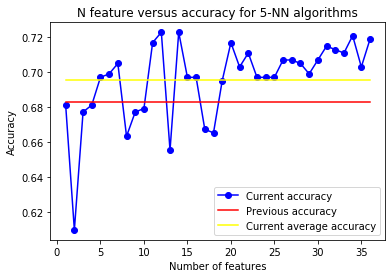

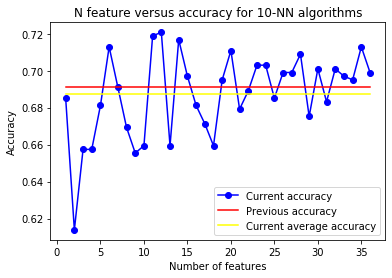

In [11]:
from statistics import mean
# Part2 Feature Engineering  Interaction term pairs & Selection   Method1
# This method displays different top n features with its accuracy when apply 5-NN algorithms and 10-NN algorithms
# For this method, n is between 1 to 36 with all f1 * f2 taken into consideration at the same time
np.random.seed(40)
score_list_5 = []
score_list_10 = []

# Separate dataset to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34)

for n in range(1, 37):   
    # Get all features by multiplying all combinations of f1 and f2 for training data
    all_features = poly.fit_transform(X_train)
    all_features = (pd.DataFrame(all_features)).iloc[:, 1:]

    # Select n features by the highest mutual information and find its index
    index = SelectKBest(mutual_info_classif, k = n).fit(all_features, y_train).get_support(indices = True)
    index = list(index)
    
    # Get all features by multiplying all combinations of f1 and f2 for testing data
    all_features_test = poly.fit_transform(X_test)
    all_features_test = (pd.DataFrame(all_features_test)).iloc[:, 1:]
    
    # Create two new dataframes for X_train and X_test with top n features
    a = []
    b = []
    for i in range(len(index)):
        a.append(all_features.iloc[:, index[i]])
        b.append(all_features_test.iloc[:, index[i]])
    new_Xtrain = (pd.DataFrame(data = a)).transpose()
    new_Xtest = (pd.DataFrame(data = b)).transpose()
    
    # Apply 5-NN algorithms
    knn_5 = neighbors.KNeighborsClassifier(n_neighbors = 5)
    knn_5.fit(new_Xtrain, y_train)
    y_pred_5 = knn_5.predict(new_Xtest)
    score_list_5.append(accuracy_score(y_test, y_pred_5))
    
    # Apply 10-NN algorithms
    knn_10 = neighbors.KNeighborsClassifier(n_neighbors = 10)
    knn_10.fit(new_Xtrain, y_train)
    y_pred_10 = knn_10.predict(new_Xtest)
    score_list_10.append(accuracy_score(y_test, y_pred_10))
    
# Find the difference between accuracy calculated by n features and accuracy calculated by original features
# To calculate the max accuracy, the mean accuray, the number of boost accuracies and the rate of boost accuracy
diff_5_max = max(score_list_5)
boost_5 = 0
for accuracy in score_list_5:
    if accuracy > all_features_5:
        boost_5 += 1
boost_rate_5 = boost_5 / len(score_list_5)
diff_5_average = mean(score_list_5)
print(f'For 5-NN algorithms, the max accuracy is {diff_5_max}, the mean accuracy is {diff_5_average} and {boost_5} accuracies have been boosted so the boost rate is {boost_rate_5}.')

diff_10_max = max(score_list_10)
boost_10 = 0
for accuracy in score_list_10:
    if accuracy > all_features_10:
        boost_10 += 1
boost_rate_10 = boost_10 / len(score_list_10)
diff_10_average = mean(score_list_10)
print(f'For 10-NN algorithms, the max accuracy is {diff_10_max}, the mean accuracy is {diff_10_average} and {boost_10} accuracies have been boosted so the boost rate is {boost_rate_10}.')

# Create lists in preparation for plotting comparision lines
all_features_5_list = []
all_features_10_list = []
diff_5_average_list = []
diff_10_average_list = []
for i in range (1, 37):
    all_features_5_list.append(all_features_5)
    all_features_10_list.append(all_features_10)
    diff_5_average_list.append(diff_5_average)
    diff_10_average_list.append(diff_10_average)
    
# Plot the graph with n features versus accuracy when it's 5-NN algorithms
plt.plot(range(1, 37), score_list_5, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 37), all_features_5_list, color = 'red', label = 'Previous accuracy')
plt.plot(range(1, 37), diff_5_average_list, color = 'yellow', label = 'Current average accuracy')
plt.legend()
plt.title('N feature versus accuracy for 5-NN algorithms')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

# Plot the graph with n features versus accuracy when it's 10-NN algorithms
plt.plot(range(1, 37), score_list_10, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 37), all_features_10_list, color = 'red', label = 'Previous accuracy')
plt.plot(range(1, 37), diff_10_average_list, color = 'yellow', label = 'Current average accuracy')
plt.legend()
plt.title('N feature versus accuracy for 10-NN algorithms')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()    

The mean accuracy without selecting top features is 0.7168316831683168.
The max accuracy without selecting top features is 0.7445544554455445.
The mean accuracy with selecting top features is 0.687986798679868.
The max accuracy with selecting top features is 0.7188118811881188.
0 accuracies have been boosted and the boost rate is 0.0.


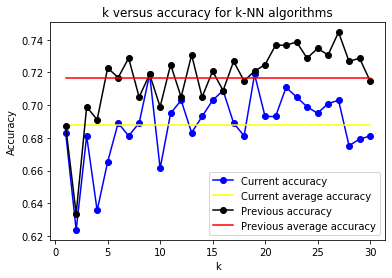

In [12]:
# This method displays the perfomance of differnet k chosen for k-NN algorithms when number of top features is fixed 
np.random.seed(40)
boost = 0
# Random select the number of top n features thus to fix n
n = random.choice(range(1, 37))
score_list_k = []

# Separate dataset to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34)

for m in range(1,31):
    # Get all features by multiplying all combinations of f1 and f2 for training data
    all_features = poly.fit_transform(X_train)
    all_features = (pd.DataFrame(all_features)).iloc[:, 1:]
    
    # Select n features by the highest mutual information and find its index (n is fixed)
    index = SelectKBest(mutual_info_classif, k = n).fit(all_features, y_train).get_support(indices = True)
    index = list(index)
    
    # Get all features by multiplying all combinations of f1 and f2 for testing data
    all_features_test = poly.fit_transform(X_test)
    all_features_test = (pd.DataFrame(all_features_test)).iloc[:, 1:]
    
    # Create two new dataframes with top n features
    a = []
    b = []
    for i in range(len(index)):
        a.append(all_features.iloc[:, index[i]])
        b.append(all_features_test.iloc[:, index[i]])
    new_Xtrain = (pd.DataFrame(data = a)).transpose()
    new_Xtest = (pd.DataFrame(data = b)).transpose()
    
    # Apply k-NN algorithms 
    knn_k = neighbors.KNeighborsClassifier(n_neighbors = m)
    knn_k.fit(new_Xtrain, y_train)
    y_pred_k = knn_k.predict(new_Xtest)
    score_list_k.append(accuracy_score(y_test, y_pred_k))

# Apply k-NN algorithms with original data (8 attributes)
all_features_k_score = []
for m in range(1, 31):
    knn_k = neighbors.KNeighborsClassifier(n_neighbors = m)
    knn_k.fit(X_train, y_train)
    y_pred_k = knn_k.predict(X_test)
    all_features_k = accuracy_score(y_test, y_pred_k)
    all_features_k_score.append(all_features_k)

# Create lists in preparation for plotting comparision lines
diff_k_average_list = []
diff_k_average = mean(score_list_k)
all_features_k_average_list = []
all_features_k_average = mean(all_features_k_score)
for i in range(1, 31):
    diff_k_average_list.append(diff_k_average)
    all_features_k_average_list.append(all_features_k_average)
for i in range(30):
    if score_list_k[i] > all_features_k_score[i]:
        boost += 1

# Calculate boost rate 
boost_rate = boost / len(score_list_k)     
print(f'The mean accuracy without selecting top features is {all_features_k_average}.')
print(f'The max accuracy without selecting top features is {max(all_features_k_score)}.')
print(f'The mean accuracy with selecting top features is {diff_k_average}.')
print(f'The max accuracy with selecting top features is {max(score_list_k)}.')
print(f'{boost} accuracies have been boosted and the boost rate is {boost_rate}.')

# Plot the graph with n fixed for different k-NN algorithms
plt.plot(range(1, 31), score_list_k, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 31), diff_k_average_list, color = 'yellow', label = 'Current average accuracy')
plt.plot(range(1, 31), all_features_k_score, color = 'black', marker = 'o', label = 'Previous accuracy')
plt.plot(range(1, 31), all_features_k_average_list, color = 'red', label = 'Previous average accuracy')
plt.legend()
plt.title('k versus accuracy for k-NN algorithms')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()     

24 accuracies have been boosted and the boost rate is 0.8571428571428571.


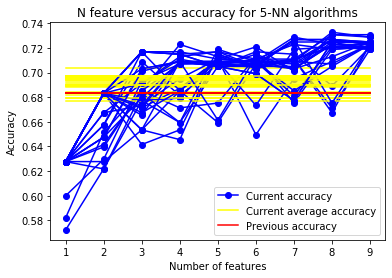

In [13]:
# Part2 Feature Engineering  Interaction term pairs & Selection   Method2
# This method displays different top n features with its accuracy when apply 5-NN algorithms
# For this method, n is between 1 to 9 with one f1 * f2 taken into consideration at each time
np.random.seed(40)
boost = 0
# Create list in preparation for plotting comparision line
all_features_5_list = []
for i in range (1, 10):
    all_features_5_list.append(all_features_5)
    
# Separate dataset to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34)
    
for m in range(9, 37):
    score_list_5 = []
    for n in range(1, 10): 
        # Get all features by multiplying all combinations of f1 and f2 for training data
        # At each time, pick one more feature and then add to dataframe
        all_features = poly.fit_transform(X_train)
        all_features = (pd.DataFrame(all_features)).iloc[:, 1:]
        df = (all_features.copy()).iloc[:, :8]
        df[9] = all_features[m]
        
        # Select n features by the highest mutual information and find its index
        index = SelectKBest(mutual_info_classif, k = n).fit(df, y_train).get_support(indices = True)
        index = list(index)
        
        # Get all features by multiplying all combinations of f1 and f2 for testing data
        all_features_test = poly.fit_transform(X_test)
        all_features_test = (pd.DataFrame(all_features_test)).iloc[:, 1:]
        df_test = (all_features_test.copy()).iloc[:, :8]
        df_test[9] = all_features[m]
        
        # Create two new dataframes with top n features
        a = []
        b = []
        for i in range(len(index)):
            a.append(df.iloc[:, index[i]])
            b.append(df_test.iloc[:, index[i]])
        new_Xtrain = (pd.DataFrame(data = a)).transpose()
        new_Xtest = (pd.DataFrame(data = b)).transpose()
        
        # Apply 5-NN algorithms
        knn_5 = neighbors.KNeighborsClassifier(n_neighbors = 5)
        knn_5.fit(new_Xtrain, y_train)
        y_pred_5 = knn_5.predict(new_Xtest)
        score_list_5.append(accuracy_score(y_test, y_pred_5))
        
    # Calculate the number of boost and create a list in preparation for plotting comparision line
    diff_5_average = mean(score_list_5)    
    if diff_5_average > all_features_5:
        boost += 1
    diff_5_average_list = []
    for i in range (1, 10):
        diff_5_average_list.append(diff_5_average)
        
    # Plot the lines with n features versus accuracy when it's 5-NN algorithms by choosing different attribute 
    plt.plot(range(1, 10), score_list_5, color = 'blue', marker = 'o')
    plt.plot(range(1, 10), diff_5_average_list, color = 'yellow')
    plt.plot(range(1, 10), all_features_5_list, color = 'red')
    
# Calculate boost rate (with 28 new attributes)
boost_rate = boost / 28  
print(f'{boost} accuracies have been boosted and the boost rate is {boost_rate}.')

# Plot the graph with n features versus accuracy when it's 5-NN algorithms 
plt.plot(range(1, 10), score_list_5, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 10), diff_5_average_list, color = 'yellow', label = 'Current average accuracy')
plt.plot(range(1, 10), all_features_5_list, color = 'red', label = 'Previous accuracy')
plt.legend()
plt.title('N feature versus accuracy for 5-NN algorithms')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

1 accuracies have been boosted and the boost rate is 0.03571428571428571.


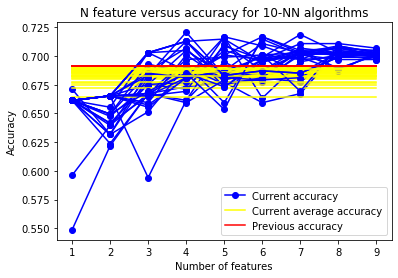

In [14]:
# Part2 Feature Engineering  Interaction term pairs & Selection   Method2
# This method displays different top n features with its accuracy when apply 10-NN algorithms
# For this method, n is between 1 to 9 with one f1 * f2 into consideration at each time
np.random.seed(40)
boost = 0
# Create list in preparation for plotting comparision line
all_features_10_list = []
for i in range (1, 10):
    all_features_10_list.append(all_features_10)

# Separate dataset to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34)
    
for m in range(9, 37):
    score_list_10 = []
    for n in range(1, 10):
        
        # Get all features by multiplying all combinations of f1 and f2 for training data
        all_features = poly.fit_transform(X_train)
        all_features = (pd.DataFrame(all_features)).iloc[:, 1:]
        df = (all_features.copy()).iloc[:, :8]
        df[9] = all_features[m]

        # Select n features by the highest mutual information and find its index
        index = SelectKBest(mutual_info_classif, k = n).fit(df, y_train).get_support(indices = True)
        index = list(index)
        
        # Get all features by multiplying all combinations of f1 and f2 for testing data
        all_features_test = poly.fit_transform(X_test)
        all_features_test = (pd.DataFrame(all_features_test)).iloc[:, 1:]
        df_test = (all_features_test.copy()).iloc[:, :8]
        df_test[9] = all_features[m]     
        
        # Create two new dataframes with top n features
        a = []
        b = []
        for i in range(len(index)):
            a.append(df.iloc[:, index[i]])
            b.append(df_test.iloc[:, index[i]])
        new_Xtrain = (pd.DataFrame(data = a)).transpose()
        new_Xtest = (pd.DataFrame(data = b)).transpose()
        
        # Apply 10-NN algorithms
        knn_10 = neighbors.KNeighborsClassifier(n_neighbors = 10)
        knn_10.fit(new_Xtrain, y_train)
        y_pred_10 = knn_10.predict(new_Xtest)
        score_list_10.append(accuracy_score(y_test, y_pred_10))
        
    # Calculate the number of boost and create list in preparation for plotting comparision line
    diff_10_average = mean(score_list_10) 
    if diff_10_average > all_features_10:
        boost += 1
    diff_10_average_list = []
    for i in range (1, 10):
        diff_10_average_list.append(diff_10_average)
        
    # Plot the lines with n features versus accuracy when it's 10-NN algorithms by choosing different attribute 
    plt.plot(range(1, 10), score_list_10, color = 'blue', marker = 'o')
    plt.plot(range(1, 10), diff_10_average_list, color = 'yellow')
    plt.plot(range(1, 10), all_features_10_list, color = 'red')
    
# Calculate boost rate (with 28 new attributes)
boost_rate = boost / 28  
print(f'{boost} accuracies have been boosted and the boost rate is {boost_rate}.')

# Plot the graph with n features versus accuracy when it's 10-NN algorithms 
plt.plot(range(1, 10), score_list_10, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 10), diff_10_average_list, color = 'yellow', label = 'Current average accuracy')
plt.plot(range(1, 10), all_features_10_list, color = 'red', label = 'Previous accuracy')
plt.legend()
plt.title('N feature versus accuracy for 10-NN algorithms')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

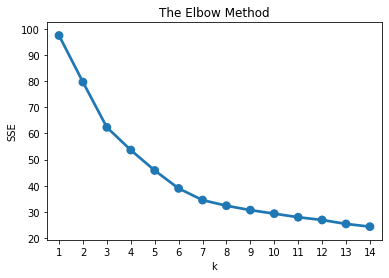

In [15]:
# Part2 Feature Engineering  Clustering labels 
# Separate dataset to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34)
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 15):  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(X_train)   
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_ 
    
# Add the plot title, x and y axis labels
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

For 5-NN algorithms, the max accuracy is 0.7227722772277227, the mean accuracy is 0.6904290429042904 and 5 accuracies have been boosted so the boost rate is 0.5555555555555556
For 10-NN algorithms, the maximum accuracy is 0.7029702970297029, the mean accuracy is 0.6807480748074808 and 3 accuracies have been boosted so the boost rate is 0.3333333333333333


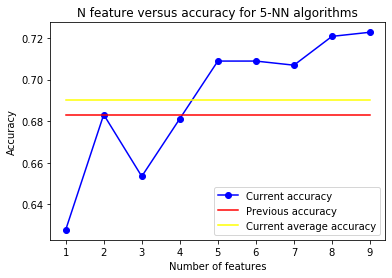

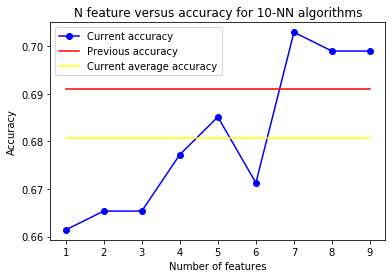

In [16]:
# Part2 Feature Engineering  Clustering labels
# This method displays different top n features with its accuracy when apply 5-NN algorithms and 10-NN algorithms
np.random.seed(40)
score_list_5 = []
score_list_10 = []

# Separate dataset to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34)

for n in range(1, 10):        
    # Compute K-Means with k = 3 from Elbow Method
    kmeans = KMeans(n_clusters = 3).fit(X_train)
    centroids = kmeans.cluster_centers_
    idx,_ = vq(X_train, centroids)
    
    # Create a new dataframe by adding cluster attribute on the basis of X_train
    new_feature_train = X_train.copy()
    new_feature_train = pd.DataFrame(new_feature_train)
    new_feature_train['Cluster'] = idx
    
    # Select n features by the highest mutual information and find the index  
    index = SelectKBest(mutual_info_classif, k = n).fit(new_feature_train, y_train).get_support(indices = True)
    index = list(index)
    new_feature_test = X_test.copy() 
    array_new_feature_test = new_feature_test.values
    
    # Find the cluster for X_test by calculating the distance to the nearest centroid
    cluster_list = []
    for m in range(len(new_feature_test)):
        dist_list = []
        for i in range (3):
            dist_cluster = 0       
            for j in range (len(centroids[0])):
                dist_cluster += (centroids[i][j] - array_new_feature_test[m][j]) ** 2         
            dist_list.append(dist_cluster)      
        for n in range(3):
            if dist_list[n] == min(dist_list):
                cluster_list.append(n)
                break
                
    # Create a new dataframe by adding cluster attribute on the basis of X_test     
    new_feature_test = pd.DataFrame(new_feature_test)
    new_feature_test['Cluster'] = cluster_list
    
    # Create two new dataframes with top n features
    a = []
    b = []
    for i in range(len(index)):
        a.append(pd.DataFrame(new_feature_train).iloc[:, index[i]])
        b.append(pd.DataFrame(new_feature_test).iloc[:, index[i]])
    new_Xtrain = (pd.DataFrame(data = a)).transpose()
    new_Xtest = (pd.DataFrame(data = b)).transpose() 
    
    # Apply 5-NN algorithms
    knn_5 = neighbors.KNeighborsClassifier(n_neighbors = 5)
    knn_5.fit(new_Xtrain, y_train)
    y_pred_5 = knn_5.predict(new_Xtest)
    score_list_5.append(accuracy_score(y_test, y_pred_5))
    
    # Apply 10-NN algorithms
    knn_10 = neighbors.KNeighborsClassifier(n_neighbors = 10)
    knn_10.fit(new_Xtrain, y_train)
    y_pred_10 = knn_10.predict(new_Xtest)
    score_list_10.append(accuracy_score(y_test, y_pred_10))
    
# Find the difference between accuracy calculated by n features and accuracy calculated by original features
# To calculate the max accuracy, the mean accuracy the number of boost accuracies and the rate of boost accuracy.
diff_5_max = max(score_list_5)
boost_5 = 0
for accuracy in score_list_5:
    if accuracy > all_features_5:
        boost_5 += 1
boost_rate_5 = boost_5 / len(score_list_5)
diff_5_average = mean(score_list_5)
print(f'For 5-NN algorithms, the max accuracy is {diff_5_max}, the mean accuracy is {diff_5_average} and {boost_5} accuracies have been boosted so the boost rate is {boost_rate_5}')

diff_10_max = max(score_list_10)
boost_10 = 0
for accuracy in score_list_10:
    if accuracy > all_features_10:
        boost_10 += 1
boost_rate_10 = boost_10 / len(score_list_10)
diff_10_average = mean(score_list_10)
print(f'For 10-NN algorithms, the maximum accuracy is {diff_10_max}, the mean accuracy is {diff_10_average} and {boost_10} accuracies have been boosted so the boost rate is {boost_rate_10}')

# Create lists in preparation for plotting
all_features_5_list = []
all_features_10_list = []
diff_5_average_list = []
diff_10_average_list = []
for i in range (1, 10):
    all_features_5_list.append(all_features_5)
    all_features_10_list.append(all_features_10)
    diff_5_average_list.append(diff_5_average)
    diff_10_average_list.append(diff_10_average)

# Plot the graph with n features versus accuracy when it's 5-NN algorithms   
plt.plot(range(1, 10), score_list_5, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 10), all_features_5_list, color = 'red', label = 'Previous accuracy')
plt.plot(range(1, 10), diff_5_average_list, color = 'yellow', label = 'Current average accuracy')
plt.legend()
plt.title('N feature versus accuracy for 5-NN algorithms')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

# Plot the graph with n features versus accuracy when it's 10-NN algorithms
plt.plot(range(1, 10), score_list_10, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 10), all_features_10_list, color = 'red', label = 'Previous accuracy')
plt.plot(range(1, 10), diff_10_average_list, color = 'yellow', label = 'Current average accuracy')
plt.legend()
plt.title('N feature versus accuracy for 10-NN algorithms')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

The mean accuracy without selecting top features is 0.7168316831683168.
The max accuracy without selecting top features is 0.7445544554455445.
The mean accuracy with selecting top features is 0.7137293729372937.
The max accuracy with selecting top features is 0.7425742574257426.
9 accuracies have been boosted and the boost rate is 0.3.


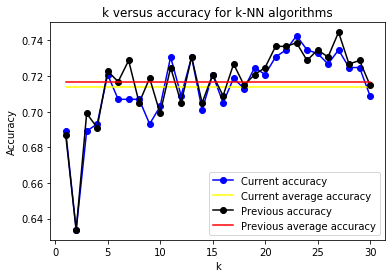

In [17]:
# This method displays the perfomance of differnet k chosen for k-NN algorithms when number of top features is fixed 
np.random.seed(40)
boost = 0
# Random select the number of top g features thus to fix g
g = random.choice(range(1, 10))
score_list_k = []

# Separate dataset to training data and testing data
X_train, X_test, y_train, y_test = train_test_split(copy1, classlabel, train_size = 0.66, test_size = 0.34)

for k in range(1, 31): 
    # Compute K-Means with k = 3
    kmeans = KMeans(n_clusters = 3).fit(X_train)
    centroids = kmeans.cluster_centers_
    idx,_ = vq(X_train, centroids)
    
    # Create a new dataframe by adding cluster attribute on the basis of X_train
    new_feature_train = X_train.copy()
    new_feature_train = pd.DataFrame(new_feature_train)
    new_feature_train['Cluster'] = idx
    
    # Select g features by the highest mutual information and find the index (g is fiexed)
    index = SelectKBest(mutual_info_classif, k = g).fit(new_feature_train, y_train).get_support(indices = True)
    index = list(index)
    new_feature_test = X_test.copy() 
    array_new_feature_test = new_feature_test.values
    
    # Find the cluster for X_test by calculating the distance to the nearest centroid
    cluster_list = []
    for m in range(len(new_feature_test)):
        dist_list = []
        for i in range (3):
            dist_cluster = 0       
            for j in range (len(centroids[0])):
                dist_cluster += (centroids[i][j] - array_new_feature_test[m][j]) ** 2         
            dist_list.append(dist_cluster)      
        for n in range(3):
            if dist_list[n] == min(dist_list):
                cluster_list.append(n)
                break
                
    # Create a new dataframe by adding cluster attribute on the basis of X_test     
    new_feature_test = pd.DataFrame(new_feature_test)
    new_feature_test['Cluster'] = cluster_list
    
    # Create two new dataframes with top g features (g is fixed)
    a = []
    b = []
    for i in range(len(index)):
        a.append(pd.DataFrame(new_feature_train).iloc[:, index[i]])
        b.append(pd.DataFrame(new_feature_test).iloc[:, index[i]])
    new_Xtrain = (pd.DataFrame(data = a)).transpose()
    new_Xtest = (pd.DataFrame(data = b)).transpose() 
    
    # Apply k-NN algorithms
    knn_k = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn_k.fit(new_Xtrain, y_train)
    y_pred_k = knn_k.predict(new_Xtest)
    score_list_k.append(accuracy_score(y_test, y_pred_k))   

all_features_k_score = []
for k in range(1, 31):
    knn_k = neighbors.KNeighborsClassifier(n_neighbors = k)
    knn_k.fit(X_train, y_train)
    y_pred_k = knn_k.predict(X_test)
    all_features_k = accuracy_score(y_test, y_pred_k)
    all_features_k_score.append(all_features_k)        
    
# Create lists in preparation for plotting comparision lines
diff_k_average_list = []
diff_k_average = mean(score_list_k)
all_features_k_average_list = []
all_features_k_average = mean(all_features_k_score)
for i in range(1, 31):
    diff_k_average_list.append(diff_k_average)
    all_features_k_average_list.append(all_features_k_average)  
for i in range(30):
    if score_list_k[i] > all_features_k_score[i]:
        boost += 1

# Calculate boost rate 
boost_rate = boost / len(score_list_k) 
print(f'The mean accuracy without selecting top features is {all_features_k_average}.')
print(f'The max accuracy without selecting top features is {max(all_features_k_score)}.')
print(f'The mean accuracy with selecting top features is {diff_k_average}.')
print(f'The max accuracy with selecting top features is {max(score_list_k)}.')
print(f'{boost} accuracies have been boosted and the boost rate is {boost_rate}.')    

# Plot the graph with n fixed for different k-NN algorithms
plt.plot(range(1, 31), score_list_k, color = 'blue', marker = 'o', label = 'Current accuracy')
plt.plot(range(1, 31), diff_k_average_list, color = 'yellow', label = 'Current average accuracy')
plt.plot(range(1, 31), all_features_k_score, color = 'black', marker = 'o', label = 'Previous accuracy')
plt.plot(range(1, 31), all_features_k_average_list, color = 'red', label = 'Previous average accuracy')
plt.legend()
plt.title('k versus accuracy for k-NN algorithms')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()     

Comment: 

The selection of top n features is calculated with mutual information by function SelectKBest. For interaction term pairs and selection part, two methods are provided. The first method is to expand previous 8 attributes to 36 attributes by multiply each two pairs and then get top n features (n from 1 to 36) from these 36 attributes. The highest accuracy occurs when top 14 features are used for classification with 5-NN algorithms and the accuracy is around 0.73. The highest accuracy occurs when top 22 or 36 features are used for classification with 10-NN algorithms and the accuracy is around 0.71. The second method is to expand previous 8 attributes to 9 attributes with the one selected from 28 new attributes and then get top n features (n from 1 to 9) from these 9 attributes. For clustering labels and selection part, by using Elbow Method, as the plot looks like an arm, it's clear that there's a huge reduction in variation with k = 3, so the elbow on the arm is optimal k which is 3. The highest accuracy occurs when top 9 features are used for classification with 5-NN algorithms and the accuracy is around 0.72. The highest accuracy occurs when top 7 features are used for classification with 10-NN algorithms and the accuracy is around 0.70. 

Clustering labels and selection: For method1, it's more likely to increase the accuracy. Because the accuracy boost rate for 5-NN algorithms is around 0.72 with average accuracy boosts a lot and the accuracy boost rate for 10-NN algorithms is around 0.50. So for these two algorithms, the rate of accuracy boost is at least 0.50. So it's more reasonable to have the boost. The accuracy rate may also related to the selection of k for k-NN algorithms, so the plot for k versus accuracy with top n features fixed is also provided above. For method2, more than half data's accuracy has been improved for 5-NN algorithms with boost rate 0.86 but less than half data's accuracy has been increased for 10-NN algorithms with boost rate 0.04. At this stage, the existence of accuracy boost may depend on the choice for k of k-NN algorithms. 

Clustering labels and selection: It may not deliver an accuracy boost. In spite that the accuracy boost rate for 5-NN algorithms is around 0.56，the accuracy boost rate for 10-NN algorithms is around 0.33. As for 5-NN algorithms, just little than half data's accuracy has been improved but much less than half data's accuracy has been increased for 10-NN algorithms. As a result, it's predicted that there may not a boost on accuracy. At this stage, the existence of accuracy boost may related to the choice for k of k-NN algorithms. The plot for k versus accuracy with top n features fixed is also provided above and it generates that the boost rate is still low which supports the assumption. 